In [2]:
!pip install hdbscan &> /dev/null

# Import dataset
from sklearn.datasets import fetch_california_housing

# Data Analysis
import pandas as pd
import numpy as np
import math

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin

# Model training and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

#Models
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn import svm
from sklearn import tree
from sklearn.neighbors import KNeighborsRegressor
from hdbscan import HDBSCAN
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb

# Ignore noise warning
import warnings
warnings.filterwarnings('ignore')

In [3]:
def create_df():
  # creación dataset e información dataset
  california = fetch_california_housing()
  df = pd.DataFrame(data=np.c_[california.data, california.target],
                  columns = california.feature_names + california.target_names)
  return california, df

def outliers_detection(df, var, percentage):
  # describe function
  desc = pd.DataFrame(df[var].describe()).T.round(2)
  display(desc.loc[:, desc.columns != 'count'])
  # possible outliers in var
  print('Possible Outliers in %s:' % var)
  out_ = set(np.round(df[var][df[var] > df[var].quantile(percentage)].unique(),0))
  out_ = [int(outlier) for outlier in out_]
  out_ = sorted(out_)
  print(out_, end=' ')

def outlier_replacement(df, var, limit_n):
  var_median = df[var].median()
  # Sustitución de los outliers más inverosímiles por la media
  df.loc[df[var] >= limit_n, var] = var_median
  return df

d = {}
def eval(algorithm, name_algorithm):
  y_est = algorithm.predict(X_test) 
  # Obtener el error cuadratico medio y el coeficiente R2
  MSE_tst = mean_squared_error(y_est,y_test)
  R2_coeff = algorithm.score(X_test,y_test)
  name_algorithm = name_algorithm.lower()
  if name_algorithm not in d.keys():
    d[name_algorithm] = (R2_coeff, MSE_tst)
    #pd.DataFrame.from_dict(d, orient='index')
  return 'R2: %.8f and MSE: %.8f' % (R2_coeff, MSE_tst)

class features_engineer(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X):
        return self
    def transform(self, X):
      # Geospatial feature engineering
      # Transformación de las variables geospaciales para mejorar la predicción.
      # Uso de un algoritmo density-based clustering.
      agrup = HDBSCAN(metric='canberra',
                      min_cluster_size=2, 
                      min_samples=1, 
                      ).fit(X.iloc[:,6:8]).labels_
      X['agrup'] = agrup
      X= X.drop(columns=['Latitude','Longitude'])
      return X

In [4]:
pipe = Pipeline([# tratamiento de outliers en variables
                 ("outliers_room", FunctionTransformer(outlier_replacement,
                                                      kw_args={"var":"AveRooms","limit_n":15},
                                                      )),
                 ("outliers_beds", FunctionTransformer(outlier_replacement,
                                                      kw_args={"var":"AveBedrms","limit_n":10},
                                                      )),
                 ("outliers_oocc", FunctionTransformer(outlier_replacement,
                                                      kw_args={"var":"AveOccup","limit_n":10},
                                                      )),
                 ("outliers_pop", FunctionTransformer(outlier_replacement,
                                                      kw_args={"var":"Population","limit_n":7000},
                                                      )),
                 ("outliers_inc", FunctionTransformer(outlier_replacement,
                                                      kw_args={"var":"MedInc","limit_n":10},
                                                      )),
                 # tratamiento variables geoespaciales
                 ("features eng", features_engineer()),
                 # normalización de variables
                 ("normalization", RobustScaler())
              ])

# 1. Exploratory analysis


In [5]:
df = create_df()[1]

print(create_df()[0].DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


#### 1.1. Relación y distribución de las variables

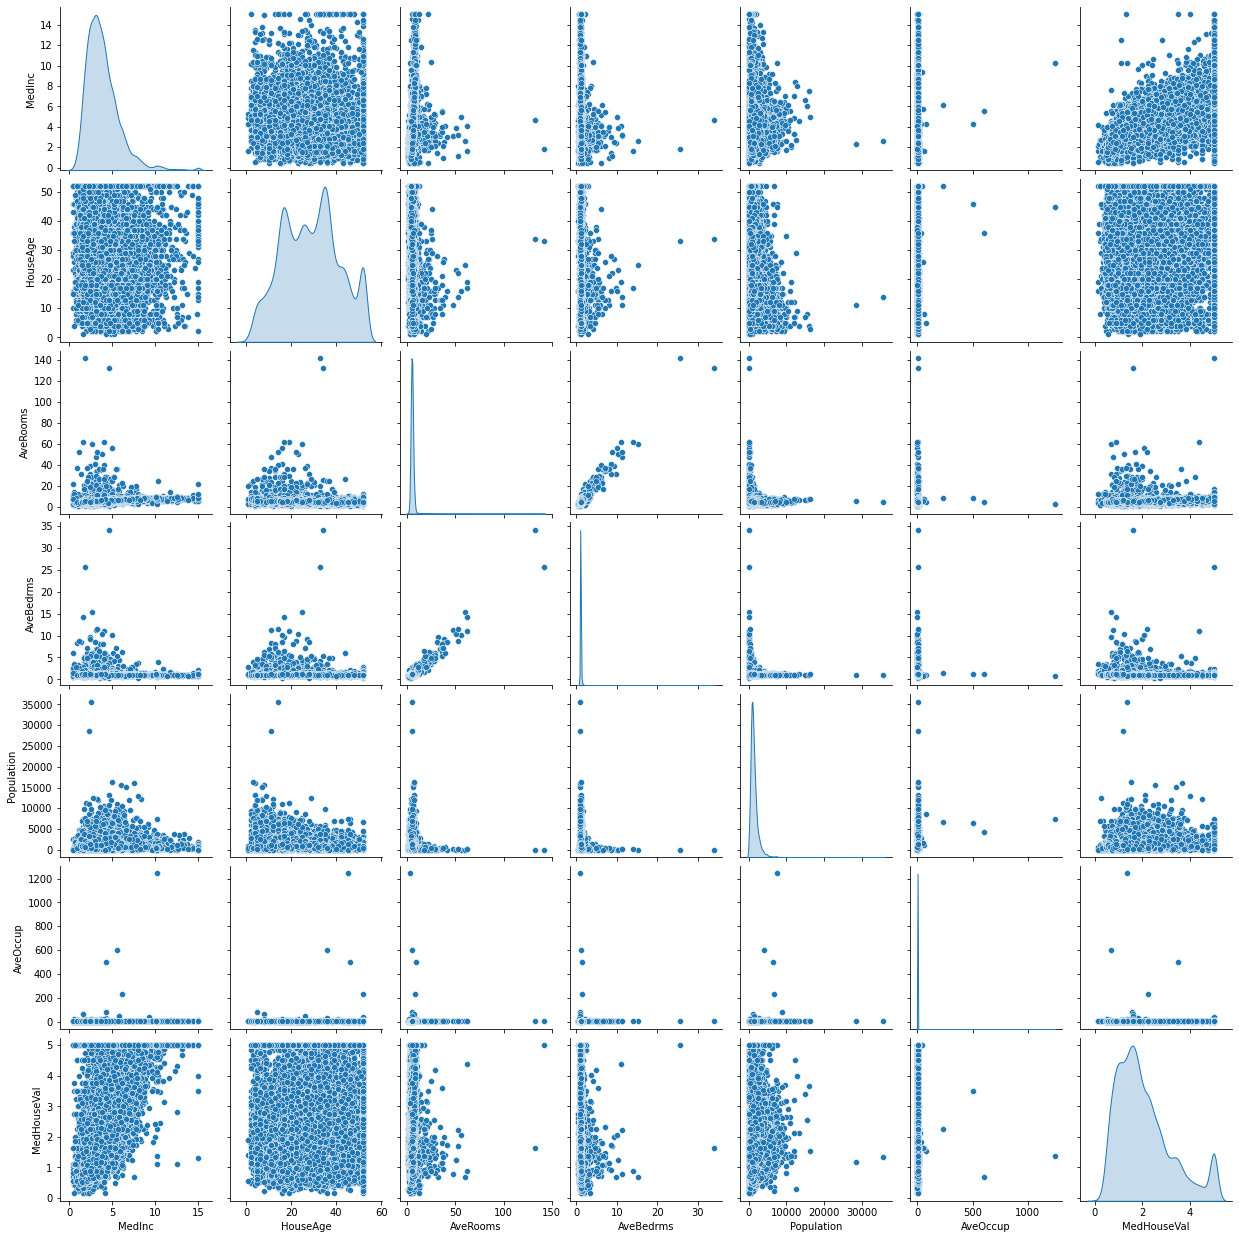

In [7]:
sns.pairplot(df.drop(columns=['Latitude','Longitude']), diag_kind='kde')

Hay claras correlaciones positivas entre:
- median income in block y median house value for California districts.
- average number of rooms per household y average number of bedrooms per household.

Hay outliers en la mayoría de variables.

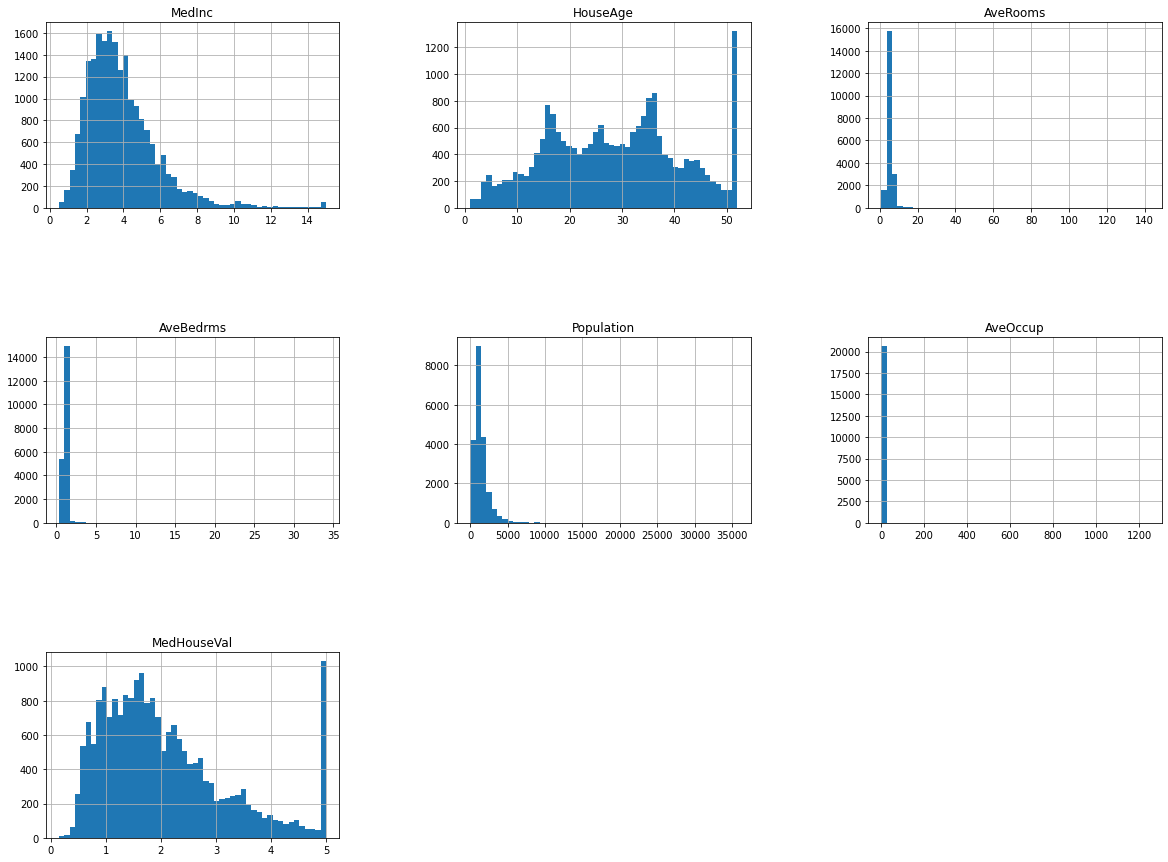

In [8]:
df.drop(columns=['Longitude','Latitude']).hist(bins=50, figsize=(20,15))
plt.subplots_adjust(hspace=0.7, wspace=0.4)

Ninguna variable sigue distribución normal.

#### 1.2. Detección de outliers

In [11]:
[outliers_detection(df, var, 0.85) for var in df.drop(columns=['Longitude','Latitude']).columns]

,mean,std,min,25%,50%,75%,max
MedInc,3.87,1.9,0.5,2.56,3.53,4.74,15.0


Possible Outliers in MedInc:
[6, 7, 8, 9, 10, 11, 12, 13, 14, 15] 

,mean,std,min,25%,50%,75%,max
HouseAge,28.64,12.59,1.0,18.0,29.0,37.0,52.0


Possible Outliers in HouseAge:
[44, 45, 46, 47, 48, 49, 50, 51, 52] 

,mean,std,min,25%,50%,75%,max
AveRooms,5.43,2.47,0.85,4.44,5.23,6.05,141.91


Possible Outliers in AveRooms:
[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 39, 40, 41, 48, 51, 53, 56, 60, 62, 133, 142] 

,mean,std,min,25%,50%,75%,max
AveBedrms,1.1,0.47,0.33,1.01,1.05,1.1,34.07


Possible Outliers in AveBedrms:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 26, 34] 

,mean,std,min,25%,50%,75%,max
Population,1425.48,1132.46,3.0,787.0,1166.0,1725.0,35682.0


Possible Outliers in Population:
[2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 2202, 2203, 2204, 2205, 2206, 2208, 2209, 2210, 2211, 2212, 2213, 2214, 2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2235, 2236, 2237, 2239, 2240, 2241, 2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 2263, 2264, 2265, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284, 2286, 2287, 2288, 2290, 2291, 2292, 2293, 2294, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 2312, 2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2323, 2324, 2325, 

,mean,std,min,25%,50%,75%,max
AveOccup,3.07,10.39,0.69,2.43,2.82,3.28,1243.33


Possible Outliers in AveOccup:
[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 21, 34, 41, 51, 64, 83, 230, 502, 600, 1243] 

,mean,std,min,25%,50%,75%,max
MedHouseVal,2.07,1.15,0.15,1.2,1.8,2.65,5.0


Possible Outliers in MedHouseVal:
[3, 4, 5] 

[None, None, None, None, None, None, None]

Los outliers más notables e inverosímiles son:
- Average number of rooms per household: no tiene sentido que la media de habitaciones por casa supere las 15 habitaciones.
- Average number of bedrooms per household: no tiene sentido que la media de dormitorios supere los 10 dormitorios.
- Average number of household members: no tiene sentido que la media de personas por casa supere los 10 miembros.

Los outliers más extremos entre el resto de variables aparecen en:
- Block group population.
- Average number of household members.


#### 1.3. Correlaciones entre variables

In [12]:
df.drop(columns=['Latitude','Longitude','MedHouseVal']).corr()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000


Existe una alta correlación entre AveRooms y AveBedrms.

In [13]:
df.drop(columns=['Latitude','Longitude']).corr()['MedHouseVal'].sort_values(ascending=False, key=abs)[1:]

MedInc        0.688075
AveRooms      0.151948
HouseAge      0.105623
AveBedrms    -0.046701
Population   -0.024650
AveOccup     -0.023737
Name: MedHouseVal, dtype: float64

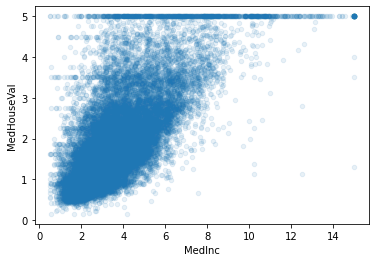

In [14]:
df.plot(kind="scatter", x="MedInc", y="MedHouseVal", alpha=0.1)

La única correlación se da entre the median house value y median income. Median house value tienda a aumentar cuando aumenta median income.

#### 1.4. Variables geoespaciales

Hay que transformar las geospatial features para mejorar la predicción.

No handles with labels found to put in legend.


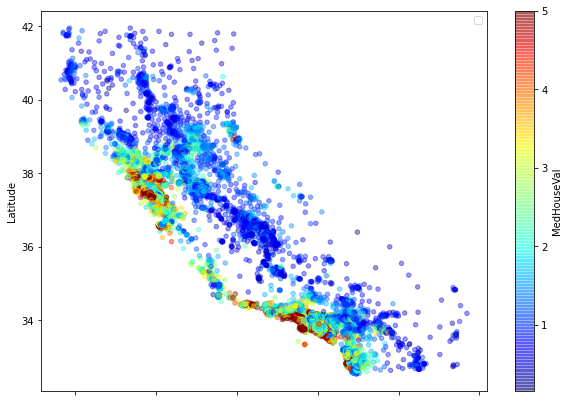

In [15]:
# Visualización del precio de las casas en cada coordenada dada.
df.plot(kind='scatter',x='Longitude',y='Latitude',
            figsize=(10,7), alpha=0.4,
            c='MedHouseVal', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()

In [16]:
# Aplicación método clustering HDBSCAN para sustituir a las coordenadas
# La métrica canberra es la que mejor resultado comparando mapas
df['space_cluster'] = HDBSCAN(metric='canberra',
                              min_cluster_size=2, 
                              min_samples=1, 
                             ).fit(df[['Latitude', 'Longitude']]).labels_

No handles with labels found to put in legend.


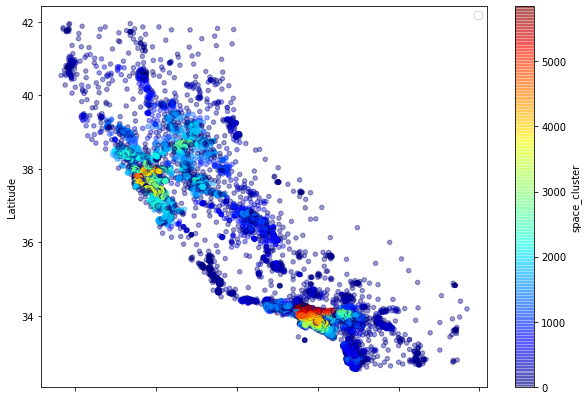

In [17]:
# Visualización de los clusters obtenidos en HDBSCAN en cada coordenada dada.
df.plot(kind='scatter',x='Longitude',y='Latitude',
            figsize=(10,7), alpha=0.4,
            c='space_cluster', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()

### 1.5. Elección de método de normalización

Para elegir la normalización adecuada se tratarán los outliers en el dataset y se procederá a elegir dicha normalización.

In [18]:
# Reemplazo de los outliers más inverosímiles en las variables de
# número de habitaciones, dormitorios y media de ocupación
unlikely_outliers = ['AveRooms','AveBedrms','AveOccup']
for var in unlikely_outliers:
  if var == 'AveRooms':
    # No tiene sentido que la media de habitaciones por casa supere 
    # las 15 habitaciones.
    limit_n = 15
  else:
    # No tiene sentido que la media de dormitorios supere los 10 
    # dormitorios o que la media de personas por casa supere los 10 miembros.
    limit_n = 10
  perc_outliers = round(len(df[df[var] >= limit_n]) / df.shape[0],4)
  print('For %s, the unlikely outliers start at %d and they appear a %.5f percent in the dataset' % (var, limit_n, perc_outliers))
  # Reemplazo outliers inverosímiles
  outlier_replacement(df, var, limit_n)

For AveRooms, the unlikely outliers start at 15 and they appear a 0.00530 percent in the dataset
For AveBedrms, the unlikely outliers start at 10 and they appear a 0.00040 percent in the dataset
For AveOccup, the unlikely outliers start at 10 and they appear a 0.00180 percent in the dataset


In [19]:
# Detección de los outliers más extremos entre el resto de variables 
extreme_outliers = ['MedInc','Population']
[outliers_detection(df, var, 0.99) for var in extreme_outliers]

,mean,std,min,25%,50%,75%,max
MedInc,3.87,1.9,0.5,2.56,3.53,4.74,15.0


Possible Outliers in MedInc:
[11, 12, 13, 14, 15] 

,mean,std,min,25%,50%,75%,max
Population,1425.48,1132.46,3.0,787.0,1166.0,1725.0,35682.0


Possible Outliers in Population:
[5807, 5810, 5820, 5826, 5839, 5840, 5860, 5871, 5899, 5913, 5917, 5935, 5964, 5982, 6000, 6002, 6012, 6034, 6047, 6068, 6071, 6075, 6080, 6083, 6085, 6109, 6133, 6159, 6160, 6161, 6163, 6187, 6214, 6223, 6234, 6241, 6242, 6266, 6270, 6274, 6291, 6295, 6296, 6301, 6303, 6330, 6370, 6389, 6420, 6437, 6443, 6456, 6474, 6511, 6532, 6544, 6578, 6583, 6600, 6626, 6640, 6652, 6657, 6664, 6666, 6675, 6686, 6693, 6700, 6716, 6763, 6780, 6799, 6810, 6835, 6837, 6846, 6852, 6897, 6902, 6912, 6931, 6945, 6990, 7009, 7014, 7025, 7030, 7087, 7096, 7111, 7132, 7139, 7158, 7174, 7178, 7180, 7205, 7211, 7221, 7228, 7235, 7249, 7266, 7270, 7273, 7282, 7301, 7302, 7305, 7307, 7343, 7363, 7417, 7427, 7429, 7431, 7443, 7450, 7460, 7463, 7517, 7540, 7560, 7588, 7596, 7600, 7604, 7608, 7644, 7653, 7665, 7679, 7694, 7732, 7766, 7775, 7817, 7919, 7984, 7985, 8012, 8117, 8152, 8190, 8222, 8276, 8361, 8380, 8437, 8551, 8652, 8656, 8686, 8721, 8733, 8738, 8768, 8793, 8805, 8824, 

[None, None]

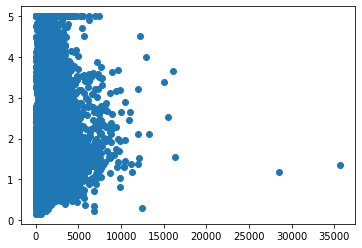

In [20]:
plt.scatter(df.Population, df.MedHouseVal)

(array([1.9816e+04, 7.1100e+02, 9.5000e+01, 1.2000e+01, 4.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([3.00000e+00, 3.57090e+03, 7.13880e+03, 1.07067e+04, 1.42746e+04,
        1.78425e+04, 2.14104e+04, 2.49783e+04, 2.85462e+04, 3.21141e+04,
        3.56820e+04]),
 <a list of 10 Patch objects>)

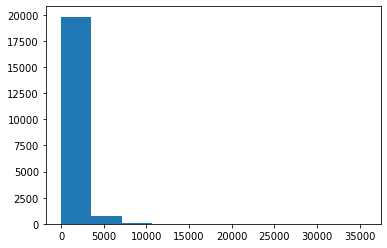

In [21]:
plt.hist(df.Population)

In [22]:
# Considero que los valores de Population a partir de 7000
# son outliers extremos.
# Éstos serán reemplazados por la mediana.
outlier_replacement(df, 'Population', 7000)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,space_cluster
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,3914
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,-1
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,3761
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,3782
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,3782
...,...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781,1338
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771,1338
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923,1343
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847,1343


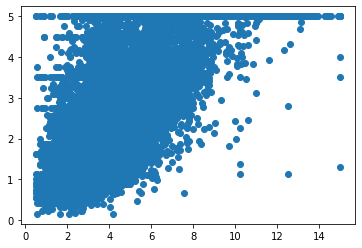

In [23]:
plt.scatter(df.MedInc, df.MedHouseVal)

(array([2247., 7436., 6098., 2990., 1060.,  428.,  178.,   93.,   47.,
          63.]),
 array([ 0.4999 ,  1.94992,  3.39994,  4.84996,  6.29998,  7.75   ,
         9.20002, 10.65004, 12.10006, 13.55008, 15.0001 ]),
 <a list of 10 Patch objects>)

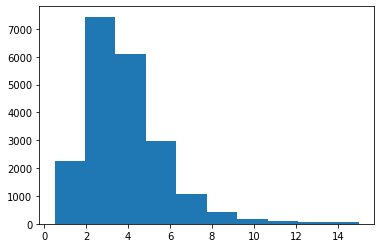

In [24]:
plt.hist(df.MedInc)

In [25]:
# Considero que los valores de MedInc a partir de 10
# son outliers extremos.
# Éstos serán reemplazados por la mediana.
outlier_replacement(df, 'MedInc', 10)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,space_cluster
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,3914
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,-1
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,3761
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,3782
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,3782
...,...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781,1338
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771,1338
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923,1343
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847,1343


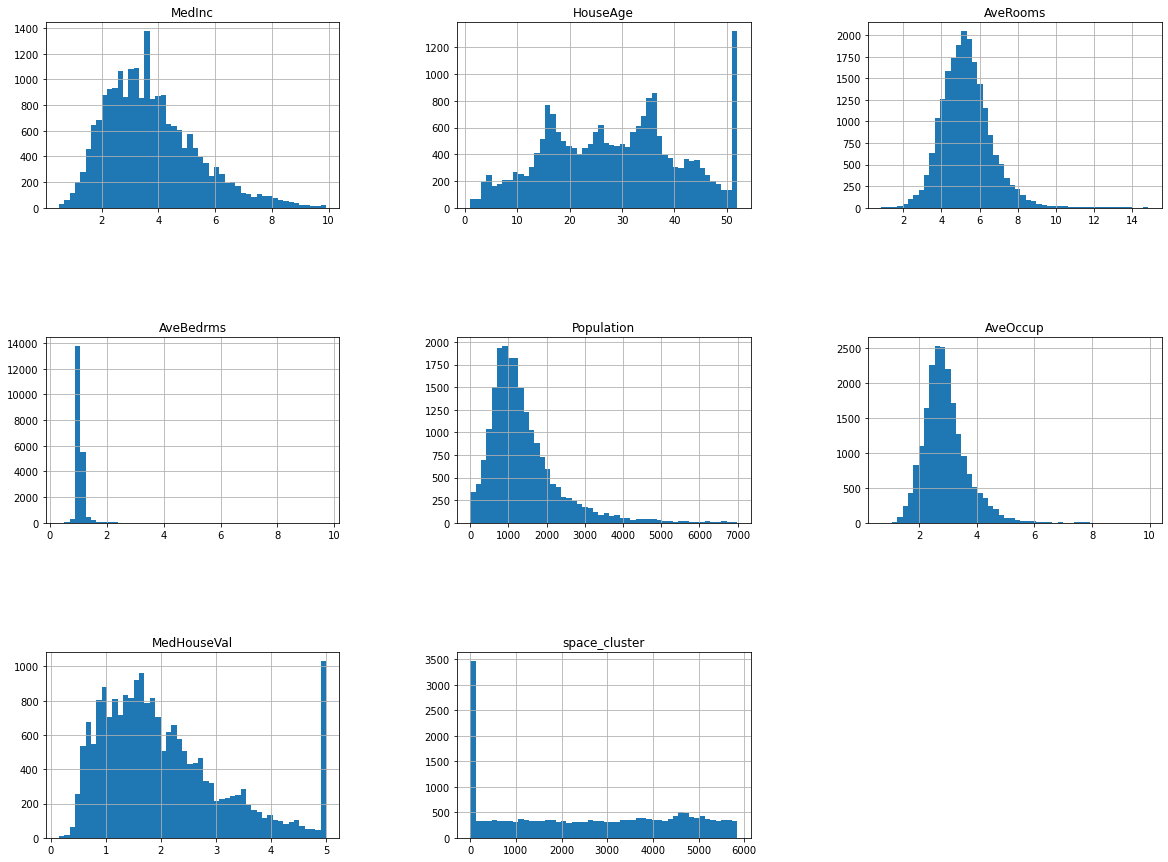

In [26]:
df.drop(columns=['Longitude','Latitude']).hist(bins=50, figsize=(20,15))
plt.subplots_adjust(hspace=0.7, wspace=0.4)

Las distribuciones en las variables transformadas siguen siendo right skew pero tienden más a una normal que antes.

In [27]:
mean = df.mean(axis=0) 
median = df.median(axis=0)

pd.concat([mean, median, mean-median], axis=1, keys=["Media", "Mediana", "Diferencia"])

,Media,Mediana,Diferencia
MedInc,3.746203,3.534750,0.211453
HouseAge,28.639486,29.000000,-0.360514
AveRooms,5.310959,5.229110,0.081849
AveBedrms,1.090197,1.048780,0.041417
Population,1378.449855,1166.000000,212.449855
AveOccup,2.918338,2.818083,0.100255
Latitude,35.631861,34.260000,1.371861
Longitude,-119.569704,-118.490000,-1.079704
MedHouseVal,2.068558,1.797000,0.271558
space_cluster,2560.104409,2552.500000,7.604409


In [28]:
#Obtener 1.5 el rango intercuartilico
iqrx15 = (df.quantile(.75)- df.quantile(.25))*1.5
#Obtener los valores maximos
maxs = df.max()
#Obtener los valores minimos
mins = df.min()
#Definir un limite superior igual a la mediana mas 1.5 veces el rango intercuartilico
sup = median+iqrx15
#Definir un limite inferior igual a la mediana menos 1.5 veces el rango intercuartilico
inf = median-iqrx15
#Comprobar si los valores maximos estan mas alla del limite superior
out_sup = maxs>sup
#Comprobar si los valores minimos estan mas alla del limite inferior
out_inf = mins<inf
#Mostramos para que variables existen valores atipicos
pd.concat([out_sup, out_inf], axis=1, keys=["Outlier Sup", "Outlier Inf"])

,Outlier Sup,Outlier Inf
MedInc,True,False
HouseAge,False,False
AveRooms,True,True
AveBedrms,True,True
Population,True,False
AveOccup,True,True
Latitude,True,False
Longitude,False,True
MedHouseVal,True,False
space_cluster,False,False


Como sigue teniendo valores atípicos, utilicemos un método de normalización robusto: RobustScaler.

# 2. Obtención de los subconjuntos de entrenamiento y testeo

In [5]:
# Generación del dataset original de nuevo
df = create_df()[1]

X = df.drop(columns=['MedHouseVal'])
y = df.MedHouseVal
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

X_train = pipe.fit_transform(X_train)
X_test = pipe.fit_transform(X_test)

# 3. Entrenamiento de modelos

### 3.1. KNN

In [31]:
# Uso de RandomizedSearchCV en lugar de GridSearchCV para ahorrar tiempo de ejecución.

kn_regressor = KNeighborsRegressor()

n_neighbors = [int(x) for x in np.linspace(2, 20, num = 10)]

leaf_size = [int(x) for x in np.linspace(10, 100, num = 10)]

param_grid =  {'weights': ['uniform', 'distance'],
               'n_neighbors': n_neighbors, 
               'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
               'metric' : ['euclidean', 'manhattan'],
               'leaf_size': leaf_size,
            }

knn = RandomizedSearchCV(kn_regressor, param_grid, cv=10, verbose=2, n_jobs=-1, refit=True)

knn.fit(X_train, y_train)

print(knn.best_params_)
eval(knn,'KNN')

Fitting 10 folds for each of 10 candidates, totalling 100 fits
{'weights': 'distance', 'n_neighbors': 18, 'metric': 'manhattan', 'leaf_size': 80, 'algorithm': 'auto'}


'R2: 0.65858501 and MSE: 0.44739327'

### 3.2. Regresión lineal con mínimos cuadrados ordinarios

In [32]:
linear_regressor = LinearRegression()

param_grid = {'positive': [True, False]}

# Definir y entrenar el modelo de regresion lineal
l_reg = GridSearchCV(linear_regressor, param_grid, cv=3, verbose=2, n_jobs=-1, refit=True)

l_reg.fit(X_train, y_train)

print(l_reg.best_params_)
eval(l_reg,'LR')

Fitting 3 folds for each of 2 candidates, totalling 6 fits
{'positive': False}


'R2: 0.47607321 and MSE: 0.68655837'

### 3.3. Regresión lineal con mínimos cuadrados ordinarios y regularizacion (RIDGE)

In [35]:
ridge_regressor = Ridge()

rang_alpha = np.logspace(-3, 1, 10)

param_grid = {'alpha': rang_alpha}

# Definir el modelo de regresion lineal con validación cruzada y entrenarlo
ridge = GridSearchCV(ridge_regressor, param_grid, cv=3, verbose=2, n_jobs=-1, refit=True)

ridge.fit(X_train, y_train)

print(ridge.best_params_)
eval(ridge, 'RIDGE')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'alpha': 10.0}


'R2: 0.47616641 and MSE: 0.68643623'

### 3.4. Regresión lineal mediante optimización con descenso de gradiente

In [36]:
sgd_regressor = SGDRegressor(max_iter=2000)

rang_eta0 = np.logspace(-3, 1, 10) 

rang_alpha = np.logspace(-3, 1, 10) 

param_grid = {'eta0': rang_eta0, 
              'alpha': rang_alpha, 
              'loss': ['squared_error', 'huber'] 
             }

sgd = GridSearchCV(sgd_regressor, param_grid, cv=3, verbose=2, n_jobs=-1, refit=True)

sgd.fit(X_train, y_train.values)

print(sgd.best_params_)
eval(sgd, 'SGD')

Fitting 3 folds for each of 200 candidates, totalling 600 fits
{'alpha': 0.001, 'eta0': 0.0027825594022071257, 'loss': 'squared_error'}


'R2: 0.47622302 and MSE: 0.68636205'

### 3.5 SVR Lineal Kernel

In [37]:
svr_l_regressor = svm.SVR(kernel='linear')

rang_C = np.arange(1, 11)

param_grid = {'C': rang_C}

lin_svc  = RandomizedSearchCV(svr_l_regressor, param_grid, cv=3, verbose=2, n_jobs=-1, refit=True)

lin_svc.fit(X_train, y_train)

print(lin_svc.best_params_)
eval(lin_svc, 'SVR_lineal')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'C': 3}


'R2: 0.44361352 and MSE: 0.72909384'

### 3.6 SVR Gaussian Kernel

In [38]:
svr_g_regressor = svm.SVR(kernel='rbf')

n_dim = X_train.shape[1]
rang_g=np.array([0.125, 0.25, 0.5, 1, 2, 4, 8]) / (np.sqrt(n_dim))

param_grid = {'C': rang_C, 'gamma': rang_g}

rbf_svc  = RandomizedSearchCV(svr_g_regressor, param_grid, cv=3, verbose=2, n_jobs=-1, refit=True)

rbf_svc.fit(X_train, y_train)

print(rbf_svc.best_params_)
eval(rbf_svc, 'SVR_gaussian')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'gamma': 0.1889822365046136, 'C': 4}


'R2: 0.68216341 and MSE: 0.41649592'

### 3.7. SVR polynomial

In [9]:
svr_p_regressor = svm.SVR(kernel='poly')
rang_d = np.arange(1,5)

param_grid = {'C': rang_C, 'degree': rang_d}

poly_svc  = RandomizedSearchCV(svr_p_regressor, param_grid, cv=3, verbose=2, n_jobs=-1, refit=True)

poly_svc.fit(X_train, y_train)

print(poly_svc.best_params_)
eval(poly_svc, 'SVR_poly')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'degree': 1, 'C': 3}


'R2: 0.44378387 and MSE: 0.72887060'

### 3.8. Ensemble Adaboost

In [10]:
# max_depth 10 da mejores resultados que max_depth 1.
# Loss = 'exponential' da mejor resultado que las otras funciones.
# Parece que a mayor max_depth mayor score.

learning_rate= np.logspace(-3, 1, 10)
# loss = ['linear','square','exponential'] 
param_grid = {'learning_rate': learning_rate}
# param_grid = {'learning_rate': learning_rate, 'loss': loss}

data = []
rang_n_learners = range(10,150,30)
for n_learners in rang_n_learners: 
    for run in range(5):
        ab = RandomizedSearchCV(AdaBoostRegressor(tree.DecisionTreeRegressor(max_depth=10), loss='exponential', n_estimators=n_learners), param_grid, cv=3, verbose=2, n_jobs=-1, refit=True)

        ab.fit(X_train,y_train)

        data.append((ab.score(X_test, y_test), n_learners, ab.best_params_['learning_rate']))

pd.DataFrame(data, columns = ["R2","Learners","Learning rate"]).sort_values(by=["R2","Learners"],ascending=[False,True]).head(10)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each

,R2,Learners,Learning rate
5,0.620121,40,0.464159
21,0.605559,130,0.166810
20,0.598946,130,0.166810
23,0.596457,130,0.166810
6,0.595640,40,0.464159
7,0.593490,40,0.464159
22,0.592889,130,0.166810
24,0.587863,130,0.166810
8,0.587334,40,0.464159
17,0.583888,100,0.166810


In [12]:
# Cálculo de la media de precisión y MSE con los mejores hiperparámetros
R2_coeff_list = []
MSE_tst_list = []
for run in range(10):
  ab = AdaBoostRegressor(tree.DecisionTreeRegressor(max_depth=10),
                            n_estimators= 130, 
                            loss='exponential',
                            learning_rate = 0.16681
                            ).fit(X_train, y_train)
  y_est = ab.predict(X_test)
  R2_coeff_list.append(ab.score(X_test, y_test))
  MSE_tst_list.append(mean_squared_error(y_est, y_test))

R2_coeff = np.mean(R2_coeff_list)
MSE_tst = np.mean(MSE_tst_list)
d["adaboost"] = (R2_coeff, MSE_tst)
print("R2: %.8f, MSE: %.8f" % (R2_coeff, MSE_tst))

R2: 0.60076881, MSE: 0.52315614


### 3.9. Ensemble XGB

In [14]:
# objective = ['reg:squarederror','reg:squaredlogerror','reg:pseudohubererror']
learning_rate= np.logspace(-3, 1, 10)
param_grid = {'learning_rate': learning_rate}
# param_grid = {'learning_rate': learning_rate, 'objective': objective}

data = []
rang_n_learners = range(10,150,30)
for n_learners in rang_n_learners: 
    for run in range(5):
        xgbr = RandomizedSearchCV(xgb.XGBRegressor(max_depth=10, n_estimators=n_learners, objective='reg:squarederror'), param_grid , cv=3, verbose=2, n_jobs=-1, refit=True)
                                  
        xgbr.fit(X_train,y_train)

        data.append((xgbr.score(X_test, y_test), n_learners, xgbr.best_params_['learning_rate']))

pd.DataFrame(data, columns = ["R2","Learners","Learning rate"]).sort_values(by=["R2","Learners"],ascending=[False,True]).head(10)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each

,R2,Learners,Learning rate
10,0.667525,70,0.059948
11,0.667525,70,0.059948
12,0.667525,70,0.059948
13,0.667525,70,0.059948
14,0.667525,70,0.059948
15,0.665535,100,0.059948
16,0.665535,100,0.059948
17,0.665535,100,0.059948
18,0.665535,100,0.059948
19,0.665535,100,0.059948


In [15]:
# Cálculo de la media de precisión y MSE con los mejores hiperparámetros
R2_coeff_list = []
MSE_tst_list = []
for run in range(10):
  xgbr = xgb.XGBRegressor(max_depth=10,
                          n_estimators= 70, 
                          learning_rate = 0.059948
                          ).fit(X_train, y_train)
  y_est = xgbr.predict(X_test)
  R2_coeff_list.append(xgbr.score(X_test, y_test))
  MSE_tst_list.append(mean_squared_error(y_est, y_test))

R2_coeff = np.mean(R2_coeff_list)
MSE_tst = np.mean(MSE_tst_list)
d["xgb"] = (R2_coeff, MSE_tst)
print("R2: %.8f, MSE: %.8f" % (R2_coeff, MSE_tst))

[15:21:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:21:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:21:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:21:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:21:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:21:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:21:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:21:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

### 3.10. Ensemble LightGBM

In [18]:
data = []

learning_rate= np.logspace(-3, 1, 10)

boosting_type = ['gbdt','dart','goss','rf']
param_grid = {'learning_rate': learning_rate, 'boosting_type':boosting_type}

rang_n_learners = range(10,150,30)
for n_learners in rang_n_learners: 
    for run in range(5):
      lgbm = RandomizedSearchCV(LGBMRegressor(max_depth=-1, n_estimators=n_learners), param_grid , cv=3, verbose=2, n_jobs=-1, refit=True)
      
      lgbm.fit(X_train,y_train)
      data.append((lgbm.score(X_test, y_test), n_learners, lgbm.best_params_['learning_rate'], lgbm.best_params_['boosting_type']))

pd.DataFrame(data, columns = ["R2","Learners","Learning rate", "boosting type"]).sort_values(by=["R2","Learners"],ascending=[False,True]).head(10)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each

,R2,Learners,Learning rate,boosting type
23,0.648286,130,0.059948,gbdt
24,0.648286,130,0.059948,gbdt
15,0.646102,100,0.059948,gbdt
16,0.646102,100,0.059948,gbdt
10,0.641638,70,0.166810,gbdt
13,0.641638,70,0.166810,gbdt
4,0.641026,10,0.464159,dart
19,0.640752,100,0.166810,gbdt
5,0.640103,40,0.464159,dart
7,0.640103,40,0.464159,dart


In [20]:
# Cálculo de la media de precisión y MSE con los mejores hiperparámetros
R2_coeff_list = []
MSE_tst_list = []
for run in range(10):
  lgbm = LGBMRegressor(max_depth=-1,
                          n_estimators= 130, 
                          learning_rate = 0.059948,
                          boosting_type = 'gbdt'
                          ).fit(X_train, y_train)
  y_est = lgbm.predict(X_test)
  R2_coeff_list.append(lgbm.score(X_test, y_test))
  MSE_tst_list.append(mean_squared_error(y_est, y_test))

R2_coeff = np.mean(R2_coeff_list)
MSE_tst = np.mean(MSE_tst_list)
d["lgbm"] = (R2_coeff, MSE_tst)
print("R2: %.8f, MSE: %.8f" % (R2_coeff, MSE_tst))

R2: 0.64828574, MSE: 0.46088953


### 3.11. Random Forest

In [8]:
max_depth = [int(x) for x in np.linspace(10, 80, num = 20)]
max_depth.append(None)

param_grid =  {#'criterion': ['mse', 'mae'],
               'max_depth': max_depth, 
               'max_features': ['auto', 'sqrt', 'log2'],
               'min_samples_leaf': np.arange(1,10),
               'min_samples_split': np.arange(2,10),
               'bootstrap': [True, False],
               'oob_score': [True, False] 
              }

data = []
rang_n_learners = range(10,100,30)
for n_learners in rang_n_learners: 
    for run in range(5):
      random_forest = RandomizedSearchCV(RandomForestRegressor(n_learners), param_grid , cv=3, verbose=2, n_jobs=-1, refit=True)
      random_forest.fit(X_train, y_train)
      data.append((random_forest.score(X_test, y_test), n_learners, random_forest.best_params_))

pd.DataFrame(data, columns = ["R2","Learners","params"]).sort_values(by=["R2","Learners"],ascending=[False,True]).head(10)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits


,R2,Learners,params
6,0.665586,40,"{'oob_score': False, 'min_samples_split': 8, '..."
10,0.664579,70,"{'oob_score': False, 'min_samples_split': 2, '..."
12,0.663315,70,"{'oob_score': False, 'min_samples_split': 3, '..."
11,0.662637,70,"{'oob_score': False, 'min_samples_split': 6, '..."
14,0.661969,70,"{'oob_score': False, 'min_samples_split': 5, '..."
7,0.657109,40,"{'oob_score': False, 'min_samples_split': 4, '..."
9,0.653199,40,"{'oob_score': False, 'min_samples_split': 4, '..."
2,0.646109,10,"{'oob_score': False, 'min_samples_split': 5, '..."
4,0.634106,10,"{'oob_score': False, 'min_samples_split': 9, '..."
8,0.607048,40,"{'oob_score': True, 'min_samples_split': 8, 'm..."


In [16]:
pd.DataFrame(data, columns = ["R2","Learners","params"]).sort_values(by=["R2","Learners"],ascending=[False,True]).params[10]

{'bootstrap': False,
 'max_depth': 43,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'oob_score': False}

In [17]:
# Cálculo de la media de precisión y MSE con los mejores hiperparámetros
R2_coeff_list = []
MSE_tst_list = []
for run in range(10):
  rf = RandomForestRegressor(max_depth = 43,
                               max_features = 'sqrt',
                               n_estimators = 70,
                               min_samples_leaf = 5,
                               min_samples_split = 2,
                               bootstrap = False,
                               oob_score = False).fit(X_train, y_train)
  y_est = rf.predict(X_test)
  R2_coeff_list.append(rf.score(X_test, y_test))
  MSE_tst_list.append(mean_squared_error(y_est, y_test))

R2_coeff = np.mean(R2_coeff_list)
MSE_tst = np.mean(MSE_tst_list)
d["rf"] = (R2_coeff, MSE_tst)
print("R2: %.8f, MSE: %.8f" % (R2_coeff, MSE_tst))

R2: 0.66004400, MSE: 0.44548139


### 3.12. GradientBoost

In [6]:
gb_regressor = GradientBoostingRegressor()

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
n_estimators.append(list(np.arange(50,200)))

param_grid =  {#'loss':['ls', 'lad', 'huber', 'quantile'],
               'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
               'max_depth': max_depth, 
               'n_estimators' : n_estimators,
               #'min_samples_leaf': np.arange(1,20),
               #'min_samples_split': np.arange(2,25),
               'max_features':['auto', 'sqrt', 'log2'],
               #'criterion': ['friedman_mse', 'mse', 'mae'],
               #'subsample':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
              }

gradientb = RandomizedSearchCV(gb_regressor, param_grid, cv=3, verbose=2, n_jobs=-1, refit=True)

gradientb.fit(X_train, y_train)

print(gradientb.best_params_)
eval(gradientb, 'GradientBooster')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'n_estimators': 1200, 'max_features': 'log2', 'max_depth': 20, 'learning_rate': 0.01}


'R2: 0.66836870 and MSE: 0.43457263'

### 3.13. Bagging

In [7]:
bagging_regressor = BaggingRegressor()

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
n_estimators.append(list(np.arange(50,200)))

param_grid =  {'base_estimator': [KNeighborsRegressor(), None],
               'max_features': [0.25, 0.5, 0.75, 1.0],
               'n_estimators' : n_estimators,
               'bootstrap_features': [True, False],
               'bootstrap': [True, False],
               'oob_score': [True, False] 
              }

bagging = RandomizedSearchCV(bagging_regressor, param_grid, cv=3, verbose=2, n_jobs=-1, refit=True)

bagging.fit(X_train, y_train)

print(bagging.best_params_)
eval(bagging, 'Bagging')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'oob_score': True, 'n_estimators': 1600, 'max_features': 0.75, 'bootstrap_features': True, 'bootstrap': True, 'base_estimator': None}


'R2: 0.54918970 and MSE: 0.59074587'

In [35]:
metric_results = pd.DataFrame.from_dict(d, orient='index', columns=['R2','MSE'])
metric_results.sort_values(by=['R2','MSE'], ascending=[False,True])

,R2,MSE
svr_gaussian,0.682163,0.416496
gradientbooster,0.668369,0.434573
xgb,0.667525,0.435678
rf,0.660044,0.445481
knn,0.658585,0.447393
lgbm,0.648286,0.460890
adaboost,0.600769,0.523156
bagging,0.549190,0.590746
sgd,0.476223,0.686362
ridge,0.476166,0.686436


El algoritmo de predicción escogida es SVR con gaussian kernel.